# 01_TFP_SBC data preprocessing

This notebook has been generated on 2020-04-18 07:59 

The objective of this notebook is to compute TFP using OP or LP algorithm using ASIF panel data

## Global steps 

The global steps to construct the dataset are the following:

* Steps:
  * Import data 2001-2007
  * Select cities and industries from the paper's table
  * Exclude outliers
  * Remove firm with different:
    *  ownership, cities and industries over time
  * Compute TFP using 2 ways:
    * full samples
    * Split by ownership

## Data source 

The data source to construct the dataset are the following:


### Big Query Dataset 
 
 - [SBC_pollution_China](https://console.cloud.google.com/bigquery?project=valid-pagoda-132423&p=valid-pagoda-132423&d=China&t=SBC_pollution_China&page=table) 
 - [asif_firm_china](https://console.cloud.google.com/bigquery?project=valid-pagoda-132423&p=valid-pagoda-132423&d=China&t=asif_firm_china&page=table) 
### Google Cloud Storage Dataset 
 
### Google Spreadsheet Dataset 


## Destination

The new dataset is available from XXX

- GS: None
- GCS: 01_TFP_SBC.gz
- BG: 01_TFP_SBC

# Load Dataset


In [1]:
from Fast_connectCloud import connector
from GoogleDrivePy.google_drive import connect_drive
from GoogleDrivePy.google_platform import connect_cloud_platform
from app_creation import studio
import pandas as pd 
import numpy as np
import pandas_profiling
from pathlib import Path
import os, re,  requests, json 

from dask.distributed import Client
from dask import dataframe as dd 
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:53597 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.59 GB


In [2]:
gs = connector.open_connection(online_connection = False, 
	path_credential = '/Users/thomas/Google Drive/Projects/Client_Oauth/Google_auth/')

service_gd = gs.connect_remote(engine = 'GS')
service_gcp = gs.connect_remote(engine = 'GCP')

gdr = connect_drive.connect_drive(service_gd['GoogleDrive'])

project = 'SBC_pollution_China'
gcp = connect_cloud_platform.connect_console(project = project,
											 service_account = service_gcp['GoogleCloudP'])

Service Google Drive and Docs, Sheet are now connected. 
Service Google Drive is stored as <googleapiclient.discovery.Resource object at 0x1a27212410> and accessible with "drive" 
Service Google Doc is stored as <googleapiclient.discovery.Resource object at 0x1a2734dad0> and accessible with "doc" 
Service Google Sheet is stored as <googleapiclient.discovery.Resource object at 0x1a274ae310>and accessible with "sheet"
Service account storage and Bigquery are now connected. 
Service account storage is stored as <google.cloud.storage.client.Client object at 0x1a274d6710> and accessible with "Storage_account" 
Service account Bigquery is stored as <google.cloud.bigquery.client.Client object at 0x1a274d6e10> and accessible with "bigquery_account"


## Load SBC_pollution_China from Google Big Query

Feel free to add description about the dataset or any usefull information.

    

In [3]:

query = (
          "SELECT * "
            "FROM China.SBC_pollution_China "

        )

df_SBC_pollution_China = gcp.upload_data_from_bigquery(query = query, location = 'US')
df_SBC_pollution_China.head()
    

,year,Period,Province_en,Lower_location,Larger_location,Coastal,cityen,geocode4_corr,TCZ_c,target_c,...,tso2_cit,tso2_i,tCOD_cit,twaste_water_cit,polluted_di,polluted_mi,polluted_thre,FE_c_i,FE_t_i,FE_t_c
0,2002,Before,Shanxi,Central,Central,False,Yuncheng,1408,TCZ,0.485030,...,24500,168934.454545,0.0,500,Above,Below,Above,11104,1573,889
1,2006,After,Hunan,Central,Central,False,Xiangtan,4303,TCZ,0.092754,...,2304,168934.454545,0.0,300,Above,Below,Above,11105,1574,420
2,2007,After,Hunan,Central,Central,False,Xiangtan,4303,TCZ,0.092754,...,2304,168934.454545,0.0,240,Above,Below,Above,11105,1572,421
3,2007,After,Liaoning,Northeast,Eastern,True,Jinzhou,2107,TCZ,0.080512,...,3200,168934.454545,0.0,0,Above,Below,Above,11103,1572,287
4,2002,Before,Liaoning,Northeast,Eastern,True,Shenyang,2101,TCZ,0.230076,...,3840,168934.454545,0.0,3500,Above,Below,Above,11106,1573,432


In [4]:
df_SBC_pollution_China = dd.from_pandas(df_SBC_pollution_China, npartitions=3)

## Load asif_firm_china from Google Big Query

Feel free to add description about the dataset or any usefull information.

    

In [5]:
%%time
query = """
WITH sum_id AS (
  SELECT 
    id, 
    case WHEN ownership = 'SOE' THEN 'SOE' ELSE 'PRIVATE' END AS OWNERSHIP, 
    year, 
    geocode4_corr, 
    cic as industry, 
    SUM(output / 10000000) as output_agg_o, 
    SUM(fa_net / 10000000) as fa_net_agg_o, 
    SUM(employment / 100000) as employment_agg_o, 
    SUM(input / 10000000) as input_agg_o, 
  FROM 
    China.asif_firm_china 
  WHERE 
    year >= 2002 
    AND year <= 2007 
    AND output > 0 
    AND fa_net > 0 
    AND employment > 0 
    AND input > 0 
  GROUP BY 
    id, 
    OWNERSHIP, 
    year, 
    geocode4_corr, 
    cic, 
    OWNERSHIP
) 
SELECT 
  sum_id.id, 
  OWNERSHIP, 
  year, 
  geocode4_corr, 
  industry, 
  output_agg_o, 
  fa_net_agg_o, 
  employment_agg_o, 
  input_agg_o, 
  occurence 
FROM 
  sum_id 
  LEFT JOIN (
    SELECT 
      id, 
      COUNT(id) as occurence 
    FROM 
      sum_id 
    GROUP BY 
      id
  ) as occ on sum_id.id = occ.id 
ORDER BY 
  occurence, 
  id, 
  year

"""

df_asif_firm_china = gcp.upload_data_from_bigquery(query = query, location = 'US')
df_asif_firm_china.head()
    

CPU times: user 35.8 s, sys: 2.9 s, total: 38.7 s
Wall time: 1min 45s


,id,OWNERSHIP,year,geocode4_corr,industry,output_agg_o,fa_net_agg_o,employment_agg_o,input_agg_o,occurence
0,000010495,PRIVATE,2002,3206,3538,0.003799,0.000129,0.00050,0.002773,1
1,000210198,PRIVATE,2002,4108,1744,0.000053,0.000174,0.00025,0.000037,1
2,000223933,SOE,2002,1305,3141,0.000510,0.000510,0.00057,0.000376,1
3,000785426,PRIVATE,2002,1201,3542,0.001200,0.000173,0.00140,0.000658,1
4,000816026,PRIVATE,2007,1306,2613,0.000869,0.000204,0.00052,0.000822,1


In [6]:
df_asif_firm_china = dd.from_pandas(df_asif_firm_china, npartitions=3)
df_asif_firm_china

,id,OWNERSHIP,year,geocode4_corr,industry,output_agg_o,fa_net_agg_o,employment_agg_o,input_agg_o,occurence
npartitions=3,,,,,,,,,,
0,object,object,int64,int64,int64,float64,float64,float64,float64,int64
382194,...,...,...,...,...,...,...,...,...,...
764388,...,...,...,...,...,...,...,...,...,...
1146581,...,...,...,...,...,...,...,...,...,...


# Workflow

In this section, we will construct the dataset, and document each step of the workflow.

Please use the following format for the documentation:

- Step 1: Select cities and industries from the paper's table
    - (optional) Underlying process description
- Step 2: Exclude outliers
    - (optional) Underlying process description
- Step 3: Remove firm with different:
    - (optional) ownership, cities and industries over time


Note: **You need to rename the last dataframe `df_final`**

In [7]:
cities = df_SBC_pollution_China['geocode4_corr'].unique().compute()
industries = df_SBC_pollution_China['industry'].unique().compute()

print("""
total cities : {}\n
total industries: {}
""".format(len(cities), len(industries)))


total cities : 228

total industries: 296



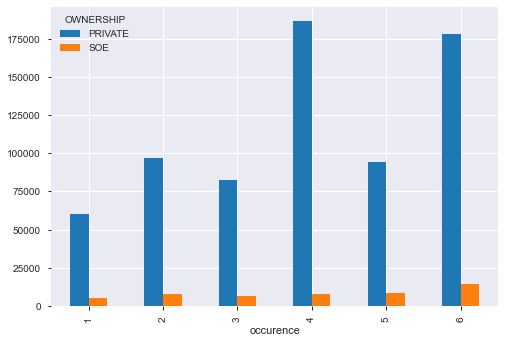

In [8]:
(df_asif_firm_china.loc[
                      (df_asif_firm_china['geocode4_corr'].isin(cities))&
                      (df_asif_firm_china['industry'].isin(industries))
                      ]
 .groupby(["OWNERSHIP",'occurence'])['occurence']
 .count()
 .compute()
 .unstack(0)
 .plot
 .bar()
)

Outliers by `ONWERSHIP`

In [9]:
outliers = (df_asif_firm_china.loc[
                      (df_asif_firm_china['geocode4_corr'].isin(cities))&
                      (df_asif_firm_china['industry'].isin(industries))
                      ]
 .groupby(["OWNERSHIP"])['output_agg_o']
 .apply(lambda x:x.quantile([.05,.25, .5, .75, .85, .9, .95]), meta=object)
 .compute()
 .unstack(0)
 .loc[[0.05, 0.95]]
)

In [13]:
(df_asif_firm_china.loc[
                      (df_asif_firm_china['geocode4_corr'].isin(cities))&
                      (df_asif_firm_china['industry'].isin(industries))
                      ]
 .groupby('OWNERSHIP')['output_agg_o']
 .apply(lambda x: x.describe(), meta=object)
).compute()

OWNERSHIP       
PRIVATE    count    6.991920e+05
           mean     7.069647e-03
           std      6.219627e-02
           min      1.000000e-07
           25%      9.744000e-04
           50%      1.982000e-03
           75%      4.690400e-03
           max      1.860000e+01
SOE        count    4.868900e+04
           mean     2.091585e-02
           std      1.615722e-01
           min      1.000000e-07
           25%      3.680000e-04
           50%      1.421900e-03
           75%      5.499000e-03
           max      6.933018e+00
dtype: float64

In [10]:
outliers#['SOE'].loc[0.05]

OWNERSHIP,PRIVATE,SOE
0.05,0.00053,0.000036
0.95,0.02047,0.053047


In [169]:
%%time
df_final = (
    (df_asif_firm_china.loc[
        (df_asif_firm_china['geocode4_corr'].isin(cities))&
        (df_asif_firm_china['industry'].isin(industries)) &
        (df_asif_firm_china['OWNERSHIP'].isin(['SOE'])) &
        (df_asif_firm_china['output_agg_o']> outliers['SOE'].loc[0.05]) &
        (df_asif_firm_china['output_agg_o']< outliers['SOE'].loc[0.95])
                      ]
     .append(
        (
        df_asif_firm_china.loc[
        (df_asif_firm_china['geocode4_corr'].isin(cities))&
        (df_asif_firm_china['industry'].isin(industries)) &
        (df_asif_firm_china['OWNERSHIP'].isin(['PRIVATE'])) &
        (df_asif_firm_china['output_agg_o']> outliers['PRIVATE'].loc[0.05]) &
        (df_asif_firm_china['output_agg_o']< outliers['PRIVATE'].loc[0.95])
     ]
        )
        )
    )
    .assign(
        switch_ownership = lambda x:
        x.groupby(['id'])['OWNERSHIP'].transform('nunique', meta=object),
        switch_cities = lambda x:
        x.groupby('id')['geocode4_corr'].transform('nunique', meta=object),
        switch_industry = lambda x:
        x.groupby('id')['industry'].transform('nunique', meta=object)
    )
    #### Test if nan in the previous computation, if yes, and occurence is 1, 
    #### then 1
    .assign(
    switch_ownership = lambda x: 
        x['switch_ownership'].where(
            ~x['switch_ownership'].isin([np.nan])& 
            ~x['occurence'].isin([1]),
            1
        ),
    switch_cities = lambda x: 
        x['switch_cities'].where(
            ~x['switch_cities'].isin([np.nan])& 
            ~x['occurence'].isin([1]),
            1
        ),
    switch_industry = lambda x: 
        x['switch_industry'].where(
            ~x['switch_industry'].isin([np.nan])& 
            ~x['occurence'].isin([1]),
            1
        ),
    )
    #### Create nan for switch
    .assign(
    switch_ownership = lambda x: 
        x['switch_ownership'].where(
            x['switch_ownership'].isin([1]),
            np.nan
        ),
    switch_cities = lambda x: 
        x['switch_cities'].where(
            x['switch_cities'].isin([1]),
            np.nan
        ),
    switch_industry = lambda x: 
        x['switch_industry'].where(
            x['switch_industry'].isin([1]),
            np.nan
        ),
    )
    .dropna()
    .reindex(columns = ['id',
                        'occurence',
                        'OWNERSHIP',
                        'year',
                        'geocode4_corr', 
                        'industry',
                        'output_agg_o',
                        'fa_net_agg_o',
                        'employment_agg_o',
                        'input_agg_o'])
).compute()


CPU times: user 1.96 s, sys: 826 ms, total: 2.79 s
Wall time: 5.58 s


In [174]:
df_final.columns

Index(['id', 'OWNERSHIP', 'year', 'geocode4_corr', 'industry', 'output_agg_o',
       'fa_net_agg_o', 'employment_agg_o', 'input_agg_o', 'occurence',
       'switch_ownership', 'switch_cities', 'switch_industry'],
      dtype='object')

In [171]:
df_final.shape

(648797, 13)

In [182]:
(df_final.loc[lambda x: 
              x['OWNERSHIP'].isin(['SOE'])]
 .groupby(['year', 'occurence'])['output_agg_o']
 .describe()
 .sort_index(level = 0, ascending = False)
)               

count      mean       std       min       25%       50%  \
year occurence                                                             
2007 6          2048.0  0.007402  0.010007  0.000038  0.001224  0.003237   
     5           433.0  0.006929  0.009920  0.000038  0.001060  0.002880   
     4           716.0  0.006030  0.009369  0.000040  0.001101  0.002410   
     3           246.0  0.008158  0.010715  0.000120  0.001160  0.003393   
     2           269.0  0.008344  0.010645  0.000061  0.001296  0.003686   
     1           312.0  0.009198  0.011434  0.000077  0.001416  0.004317   
2006 6          2098.0  0.007070  0.009649  0.000039  0.001223  0.003121   
     5          1347.0  0.003755  0.007843  0.000036  0.000223  0.000711   
     4           914.0  0.005175  0.009227  0.000037  0.000672  0.001611   
     3           623.0  0.004072  0.008186  0.000037  0.000220  0.000706   
     2           339.0  0.005500  0.008483  0.000040  0.000662  0.002056   
     1            64.0  0.004638  0.007789  0.000090  0.000495  0.001636   
2005 6          2136.0  0.006860  0.009522  0.000040  0.001200  0.002971   
     5          1416.0  0.003645  0.007644  0.000036  0.000233  0.000755   
     4          1598.0  0.004002  0.007664  0.000037  0.000394  0.001186   
     3           752.0  0.003988  0.007958  0.000038  0.000235  0.000800   
     2           379.0  0.003608  0.007299  0.000036  0.000225  0.000778   
     1            97.0  0.006737  0.010429  0.000036  0.000560  0.001800   
2004 6          2182.0  0.006160  0.008511  0.000037  0.001087  0.002654   
     5          1400.0  0.003513  0.007353  0.000037  0.000230  0.000776   
     4          1650.0  0.003763  0.007253  0.000036  0.000418  0.001132   
     3          1525.0  0.002943  0.006565  0.000037  0.000201  0.000586   
     2           581.0  0.002831  0.006816  0.000038  0.000200  0.000619   
     1          1381.0  0.002498  0.005866  0.000036  0.000146  0.000520   
2003 6          2228.0  0.005795  0.008344  0.000037  0.001053  0.002590   
     5          1451.0  0.003423  0.007194  0.000037  0.000242  0.000803   
     4          1022.0  0.003518  0.007245  0.000036  0.000285  0.001020   
     3          1236.0  0.003570  0.007045  0.000037  0.000289  0.000955   
     2          2853.0  0.003633  0.007131  0.000036  0.000275  0.000996   
     1           497.0  0.004025  0.007184  0.000037  0.000372  0.001182   
2002 6          1572.0  0.005626  0.008646  0.000039  0.000985  0.002387   
     5           909.0  0.003307  0.007426  0.000036  0.000223  0.000621   
     4           621.0  0.003527  0.007179  0.000037  0.000275  0.000884   
     3           837.0  0.003458  0.006561  0.000036  0.000245  0.000926   
     2          1932.0  0.003740  0.007239  0.000036  0.000283  0.000978   
     1          1824.0  0.003112  0.006384  0.000036  0.000205  0.000735   

                     75%       max  
year occurence                      
2007 6          0.008705  0.052040  
     5          0.007869  0.052998  
     4          0.005924  0.052322  
     3          0.009941  0.051057  
     2          0.010949  0.050843  
     1          0.013527  0.050530  
2006 6          0.008447  0.052992  
     5          0.002927  0.051618  
     4          0.004564  0.052974  
     3          0.003254  0.050060  
     2          0.006112  0.052585  
     1          0.006446  0.047783  
2005 6          0.008204  0.052883  
     5          0.002984  0.052036  
     4          0.003506  0.052923  
     3          0.003166  0.052582  
     2          0.003382  0.048524  
     1          0.009130  0.046612  
2004 6          0.007094  0.052606  
     5          0.002817  0.052831  
     4          0.003480  0.052855  
     3          0.002283  0.052609  
     2          0.001917  0.052730  
     1          0.001810  0.049995  
2003 6          0.006469  0.052956  
     5          0.002922  0.052949  
     4          0.003168  0.052432  
     3          0.003503  0.051297  
     2          0.

In [183]:
### First save locally
df_final.to_csv(
	'01_TFP_SBC.gz',
	sep=',',
	header=True,
	index=False,
	chunksize=100000,
	compression='gzip',
	encoding='utf-8')

# Profiling

In order to get a quick summary statistic of the data, we generate an HTML file with the profiling of the dataset we've just created. 

The profiling will be available at this URL after you commit a push to GitHub. 

**You need to rename the final dataframe `df_final` in the previous section to generate the profiling.**

In [ ]:
#### make sure the final dataframe is stored as df_final
### Overide the default value: 
#https://github.com/pandas-profiling/pandas-profiling/blob/master/pandas_profiling/config_default.yaml

profile = pandas_profiling.ProfileReport(df_final,
                                        check_correlation_pearson = False)
name_html = "NAME.html"
profile.to_file(output_file=name_html)

# Upload to cloud

The dataset is ready to be shared with your colleagues. 





### Move to GCS and BigQuery

We move the dataset to the following:

- **bucket**: *NEED TO DEFINE*

- **Destination_blob**: *XXXXX/Processed_*
- **name**:  *01_TFP_SBC.gz*
- **Dataset**: *China*

- **table**: *01_TFP_SBC*

### GCS

We first need to save *01_TFP_SBC* with `.gz` extension locally then we can move it
to GCS


In [ ]:

### First save locally
df_final.to_csv(
	'01_TFP_SBC.gz',
	sep=',',
	header=True,
	index=False,
	chunksize=100000,
	compression='gzip',
	encoding='utf-8')

### Then upload to GCS
bucket_name = 'NEED TO DEFINE'
destination_blob_name = 'XXXXX/Processed_'
source_file_name = '01_TFP_SBC.gz'
gcp.upload_blob(bucket_name, destination_blob_name, source_file_name)



In [ ]:


### Move to bigquery
bucket_gcs ='NEED TO DEFINE/XXXXX/Processed_/01_TFP_SBC.gz'
gcp.move_to_bq_autodetect(dataset_name= 'China',
							 name_table= '01_TFP_SBC',
							 bucket_gcs=bucket_gcs)


# Generate Studio

To generate a notebook ready to use in the studio, please fill in the variables below:

- 'project_name' : Name of the repository
- 'input_datasets' : name of the table
- 'sheetnames' : Name of the sheet, if table saved in Google Spreadsheet
- 'bigquery_dataset' : Dataset name
- 'destination_engine' : 'GCP' or 'GS,
- 'path_destination_studio' : path to `Notebooks_Ready_to_use_studio`
- 'project' : 'valid-pagoda-132423',
- 'username' : "thomas",
- 'pathtoken' : Path to GCP token,
- 'connector' : 'GBQ', ## change to GS if spreadsheet
- 'labels' : Add any labels to the variables,
- 'date_var' : Date variable

In [ ]:
labels = []
date_var = ''

In [ ]:
regex = r"(.*)/(.*)"
path = os.getcwd()
parent_path = Path(path).parent
test_str = str(parent_path)
matches = re.search(regex, test_str)
github_repo = matches.group(2)

path_credential = '/Users/Thomas/Google Drive/Projects/Data_science/Google_code_n_Oauth/Client_Oauth/Google_auth/'

dic_ = {
    
          'project_name' : github_repo,
          'input_datasets' : 'SBC_pollution_China',
          'sheetnames' : '',
          'bigquery_dataset' : 'China',
          'destination_engine' : 'GCP',
          'path_destination_studio' : os.path.join(test_str,
                                       'Notebooks_Ready_to_use_studio'),
          'project' : 'valid-pagoda-132423',
          'username' : "thomas",
          'pathtoken' : path_credential,
          'connector' : 'GBQ', ## change to GS if spreadsheet
          'labels' : labels,
          'date_var' : date_var
}
create_studio = studio.connector_notebook(dic_)
create_studio.generate_notebook_studio()

# Add data to catalogue

Now that the dataset is ready, you need to add the underlying information to the data catalogue. The data catalogue is stored in [Coda](https://coda.io/d/MasterFile-Database_dvfMWDBnHh8/MetaDatabase_suYFO#_ludIZ), more precisely, in the table named `DataSource`. 

The cells below helps you to push the information directly to the table using Coda API.

The columns are as follow:

- `Storage`: Define the location of the table
    - GBQ, GS, MongoDB
- `Theme`: Define a theme attached to the table
    - Accountancy, Complexity, Correspondance, Customer_prediction, Distance, Environment, Finance, Macro, Production, Productivity, Survey, Trade
- `Database`: Name of the dataset. Use only for GBQ or MongoDB (collection)
    - Business, China, Steamforged, Trade
- `Path`:A URL with the path of the location of the dataset
- `Filename`: Name of the table
- `Description`: Description of the table. Be very specific. 
- `Source_data`: A list of the data sources used to construct the table.
- `Link_methodology`: URL linked to the notebook
- `Dataset_documentation`: Github repository attached to the table
- `Status`: Status of the table. 
    - `Closed` if the table won't be altered in the future
    - `Active` if the table will be altered in the future
- `Profiling`: Specify if the user created a Pandas profiling
    - `True` if the profiling has been created
    - `False` otherwise
- `Profiling_URL`: Profiling URL (link to Github). Always located in `Data_catalogue/table_profiling`
- `JupyterStudio`: Specify if the user created a notebook to open the studio
    - `True` if the notebook has been created
    - `False` otherwise
- `JupyterStudio_launcher`: Notebook URL (link to Github). Always located in `Notebooks_Ready_to_use_studio`
- `Nb_projects`: Number of projects using this dataset. A Coda formula. Do not update this row
- `Created on`: Date of creation. A Coda formula. Do not update this row

Remember to commit in GitHub to activate the URL link for the profiling and Studio

In [ ]:
Storage = 'GBQ'
Theme = 'Trade' 
Database = 'China'
Description = "The table is related to"
Filename = 'SBC_pollution_China'
Status = 'Active'

In [ ]:
Source_data = ['SBC_pollution_China', 'asif_firm_china']

The next cell pushes the information to [Coda](https://coda.io/d/MasterFile-Database_dvfMWDBnHh8/Test-API_suDBp#API_tuDK4)

In [ ]:
regex = r"(.*)/(.*)"
path = os.getcwd()
parent_path = Path(path).parent
test_str = str(parent_path)
matches = re.search(regex, test_str)
github_repo = matches.group(2)

Profiling = True
if Profiling:
    Profiling_URL = 'http://htmlpreview.github.io/?https://github.com/' \
    'thomaspernet/{}/blob/master/Data_catalogue/table_profiling/{}.html'.format(github_repo,
                                                                               Filename)
else:
    Profiling_URL = ''
JupyterStudio = False
if JupyterStudio:
    JupyterStudio_URL = '"https://mybinder.org/v2/gh/thomaspernet/{0}/' \
    'master?filepath=Notebooks_Ready_to_use_studio%2F{1}_studio.ipynb'.format(github_repo, Filename)
else:
    JupyterStudio_URL = ''
### BigQuery only 
path_url = 'https://console.cloud.google.com/bigquery?project=valid-pagoda-132423' \
'&p=valid-pagoda-132423&d=China&t={}&page=table'.format(Filename)

Link_methodology = 'https://nbviewer.jupyter.org/github/thomaspernet/' \
    '{0}/blob/master/Data_preprocessing/' \
    '{1}.ipynb'.format(github_repo,
    Filename)

Dataset_documentation = 'https://github.com/thomaspernet/{}'.format(github_repo)

to_add = {
    'Storage': Storage,
    'Theme': Theme,
    'Database': Database,
    'Path_url': path_url,
    'Filename': Filename,
    'Description': Description,
    'Source_data': Source_data,
    'Link_methodology': Link_methodology,
    'Dataset_documentation': Dataset_documentation,
    'Status': Status,
    'Profiling_URL': Profiling_URL,
    'JupyterStudio_launcher': JupyterStudio_URL

}
cols= []
for key, value in to_add.items():
    coda = {
    'column': key,
    'value':value
    }
    cols.append(coda)
    
###load token coda
with open('token_coda.json') as json_file:
    data = json.load(json_file)
    
token = data[0]['token'] 
headers = {'Authorization': 'Bearer {}'.format(token)}
uri = f'https://coda.io/apis/v1beta1/docs/vfMWDBnHh8/tables/grid-HgpAnIEhpP/rows'
payload = {
  'rows': [
    {
      'cells': cols,
    },
  ],
}
req = requests.post(uri, headers=headers, json=payload)
req.raise_for_status() # Throw if there was an error.
res = req.json()